In [21]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings(action='once')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 999)
%matplotlib inline

In [22]:
def over_sampling(X, Y):
    smote = SMOTE(sampling_strategy='minority')
    return smote.fit_sample(X, Y)

In [23]:
# 讀取訓練資料
data_dir = './data'
df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))

# 將明顯的錯誤資料去除掉
df = df[df['name'] != 'LOCKHART EUGENE E']
df = df[df['name'] != 'THE TRAVEL AGENCY IN THE PARK']

X_train = df.drop(['poi'], axis=1)
Y_train = df['poi']
train_num = Y_train.shape[0]

In [24]:
print(X_train.shape)
X_train.head()

(111, 21)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


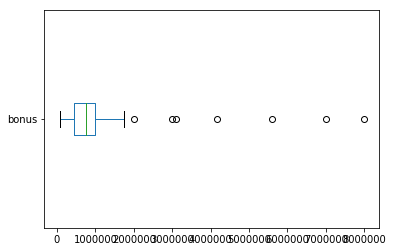

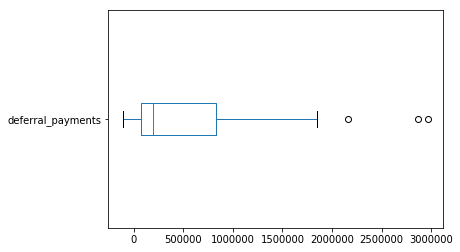

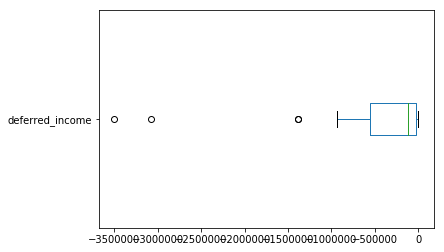

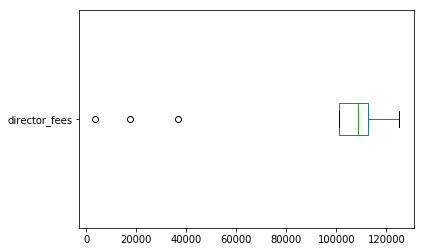

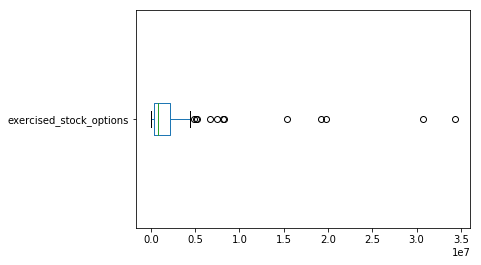

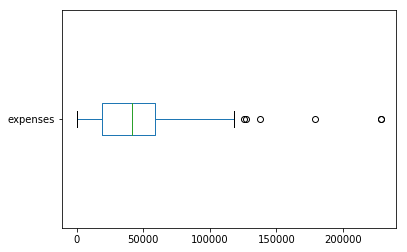

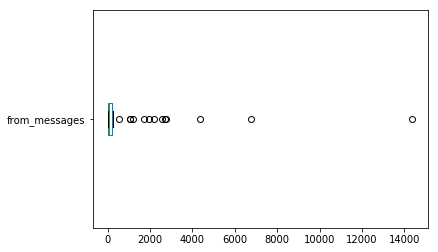

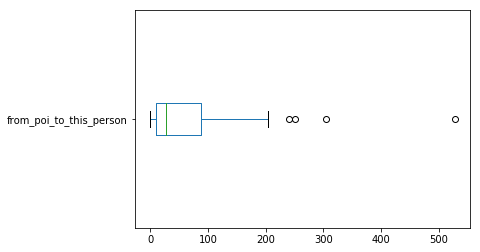

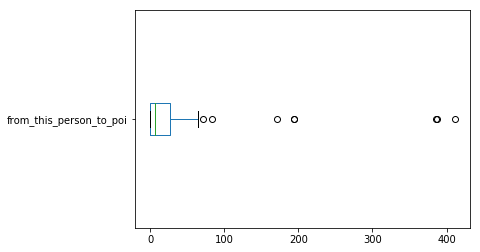

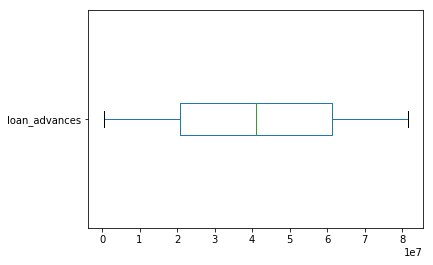

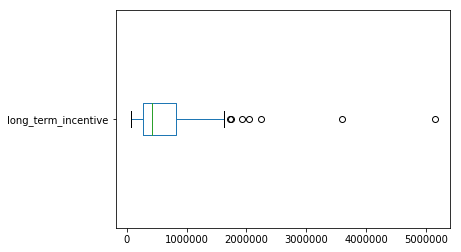

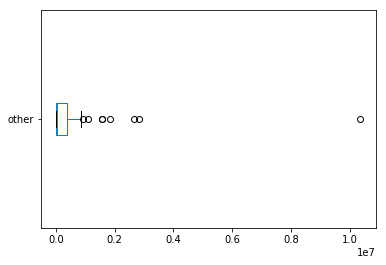

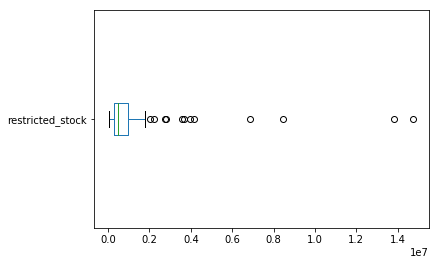

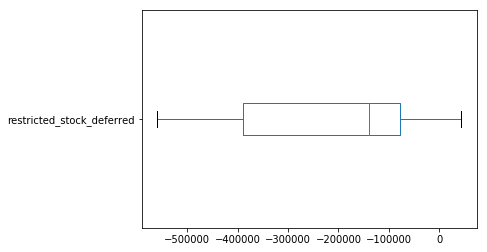

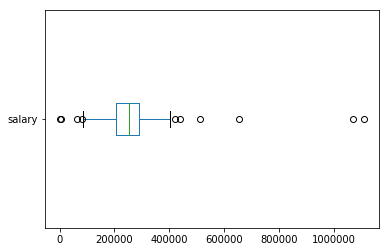

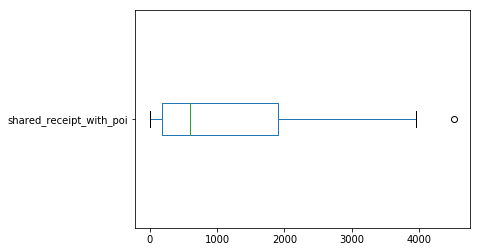

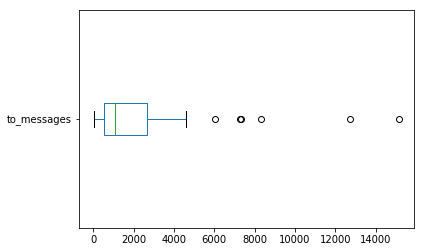

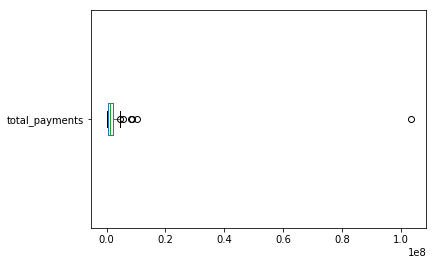

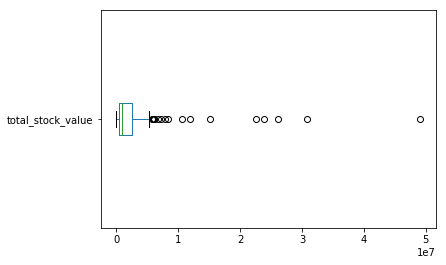

In [25]:
# 篩選數字欄位
numeric = X_train.select_dtypes(include='number')

# 將值有 0、1 兩種值的欄位篩選掉
numeric_columns = list(numeric.columns[numeric.apply(lambda x: len(x.unique()) != 2)])

for col in numeric_columns:
    X_train[col].plot.box(vert=False)
#     sns.distplot(X_train[col])
    plt.show()

In [26]:
def is_not_null(x):
    if not pd.isnull(x):
        return 1.0
    else:
        return 0.0
    
# 第一次轉換：自己決定的轉換方式
# 建議使用前先用 `df.copy()` 拷貝一份資料
def transform_1(df, manual=True):
    
    # 把最大值換成第二大
    # 也可以是最小值或其他目標值
    def replace_outlier(col, method='max', replace_to=None):   
        # 用來取得目標值
        # 如果 method 為 `max`，`fn` 就是 `df[col].max`
        fn = getattr(df[col], method)

        if pd.isnull(fn()):
            return
        
        # 用來篩選目標值
        mask = df[col] != fn()
        
        # 取得篩選過後的目標值
        if replace_to == None:
            fn_2 = getattr(df.loc[mask, col], method)
            replace_to = fn_2()
        
        # 將目標值替換掉
        df.loc[~mask, col] = replace_to
        
    # 轉換為「是否存在」
    to_is_not_null = [
        'email_address',
        'restricted_stock_deferred'
    ]
    for col in to_is_not_null:
        df['has_' + col] = df[col].apply(is_not_null)
        
    financial_cols = [
        'deferral_payments',
        'total_payments',
        'loan_advances',
        'bonus',
        'restricted_stock_deferred',
        'deferred_income',
        'total_stock_value',
        'expenses',
        'exercised_stock_options',
        'other',
        'long_term_incentive',
        'restricted_stock',
        'director_fees'
    ]
    
    if manual == True:

        # 要替換成 0 的欄位
        na_to_zero = financial_cols + [
            'from_this_person_to_poi',
            'from_poi_to_this_person',
            'from_messages',
            'to_messages',
            'shared_receipt_with_poi'
        ]
        for col in na_to_zero:
            df[col] = df[col].fillna(0)

        # 替換掉最大值
        to_replace_max = [
            'salary',
            'deferral_payments',
            'total_payments',
            'loan_advances',
            'bonus',
            'total_stock_value',
            'expenses',
            'exercised_stock_options',
            'other',
            'long_term_incentive',
            'restricted_stock',
            'director_fees'
        ]
        for col in to_replace_max:
            replace_outlier(col, 'max', replace_to=0)

        # 替換掉最小值
        to_replace_min = [
            'deferred_income',
            'restricted_stock_deferred'
        ]
        for col in to_replace_min:
            replace_outlier(col, 'min', replace_to=0)
            
        # 要替換成中位數的欄位
        na_to_median = [
            'salary'
        ]
        for col in na_to_median:
            df[col] = df[col].fillna(df[col].median())
            
        # 要做 log1p 的欄位
        to_log1p = [
            'bonus',
            'other',
            'salary',
            'expenses',
        ]
        for col in to_log1p:
            # 確保沒有負值
            if df[df[col] < 0].shape[0] == 0:
                df[col] = np.log1p(df[col])

    
    # 要 drop 掉的欄位
    to_drop = [
        'name',
        'email_address',
    ]
    df = df.drop(to_drop, axis=1)    
    
    # 和 poi 的信件往來比例
    df['ratio_to_poi'] = df['from_this_person_to_poi'] / df['from_messages']
    df['ratio_from_poi'] = df['from_poi_to_this_person'] / df['to_messages']
    df['ratio_shared_poi'] = df['shared_receipt_with_poi'] / df['to_messages']

    to_zero = [
        'ratio_to_poi',
        'ratio_from_poi',
        'ratio_shared_poi'
    ]
    for col in to_zero:
        df[col] = df[col].fillna(0)
    
    return df

In [27]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from lightgbm import LGBMClassifier

In [173]:
# 各種填補值
fills = {
    'zero': 0,
    '-1': -1,
    'mean': lambda x: getattr(x, 'mean')(),
#     'median': lambda x: getattr(x, 'median')(),
#     'max': lambda x: getattr(x, 'max')(),
#     'min': lambda x: getattr(x, 'min')(),
}

# 各種 scaler
scalers = [None, MinMaxScaler(), StandardScaler()]


voting_settings = {
    'estimators': [
        ('svc', SVC(
            gamma='auto',
            probability=True
        )),
        ('lr', LogisticRegression(
            solver='liblinear',
            max_iter=100
        )),
        ('gbc', GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.1
        )),
        ('rfc', RandomForestClassifier(
            n_estimators=100,
            max_depth=75
        )),
        ('lgbm', LGBMClassifier(
            boosting_type=None,
            max_depth=None,
            bagging_fraction=0.9,
            bagging_freq=1,
            n_estimators=100
        )),
    ],
    'weights':  [1, 1.5, 2, 3, 2.5],
    'voting': 'soft'
}

# 各種模型和參數
estimators = [
    {
        'model': VotingClassifier,
        'args_list': {
            'estimators': [
                voting_settings['estimators']
            ],
            'weights': [
                voting_settings['weights']
            ],
            'voting': [
                voting_settings['voting']
            ],
        }
    },
    
    {
        'model': SVC,
        'args_list': {
            'gamma': ['auto'],
            'probability': [True]
        }
    },
    
    {
        'model': LogisticRegression,
        'args_list': {
            'solver': ['liblinear'],
            'max_iter': [100, 1000]
        }
    },
    
    {
        'model': GradientBoostingClassifier,
        'args_list': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.05, 0.1]
        }
    },
    
    {
        'model': RandomForestClassifier,
        'args_list': {
            'n_estimators': [100],
            'max_depth': [None, 5, 50, 100]
        },
    },
    
    {
        'model': LGBMClassifier,
        'args_list': {
            'boosting_type': [None, 'rf'],
            'max_depth': [None, 10, 100],
            'bagging_fraction': [0.9],
            'bagging_freq': [1],
            'n_estimators': [10, 100]
        }
    },
]

In [174]:
# 第二次轉換：各種可能都跑看看
# 建議使用前先拷貝一份資料
def transform_2(df, fill=0, scaler=None):
    for col in df.columns:
        if type(fill).__name__ == 'function':
            df[col] = fill(df[col])
        else:
            df[col] = df[col].fillna(fill)
        
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(list(df[col].values))
        elif scaler != None and not col.startswith('has_'):
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    return df

# 資料轉換
# 建議使用前先拷貝一份資料
def transform(df, fill, scaler, manual):
    df = transform_1(df, manual)
    return transform_2(df, fill, scaler)

# 交叉測試
def compute_score(model, data, target):
    return cross_val_score(model, data, target, cv=5, error_score='raise').mean()

# 用來顯示測試結果
class Result:
    def __init__(self):
        self.result_columns = ['Estimator', 'Args', 'Filling', 'Scaler', 'Manual', 'Score']
        self.df = pd.DataFrame(columns=self.result_columns)

    def append(self, model, args, fill_name, scaler, manual, score):
        row = pd.DataFrame([[
            type(model).__name__,                                             # 模型
            args,                                                                               # 參數
            fill_name,                                                                       # 填補值
            type(scaler).__name__ if scaler != None else '-',    # scaler
            manual,                                                                         # 是否手動調整（大部分）特徵
            score                                                                              # 分數
        ]], columns=self.result_columns)
        
        self.df = self.df.append(row, ignore_index=True, sort=True)
    
    def show(self):
        # 按照分數排序
        return self.df.sort_values(by=['Score'], ascending=False)
    

def iter_args(args_list):
    keys = args_list.keys()
    for args in itertools.product(*args_list.values()):
        yield dict(zip(keys, args))

def prepare_train(X, Y, fill, scaler, manual):
    X_tmp = X.copy()  # 拷貝一份資料避免測試結果互相干擾
    X_tmp = transform(X_tmp, fill, scaler, manual)
    return over_sampling(X_tmp, Y)
        
# 把各種填補值、scaler、模型及參數都丟進去跑跑看，用 `cross_val_score` 做評分
def find_best_args(X, Y):
    result = Result()
    
    with tqdm(total=count_c()) as pbar:
        for estimator in estimators:
            for args in iter_args(estimator['args_list']):
                for fill_name, fill in fills.items():
                    for scaler in scalers:
                        for manual in [True, False]:
                            model = estimator['model'](**args)
                            X_tmp, Y_tmp = prepare_train(X, Y,fill, scaler, manual)
                            score = compute_score(model, X_tmp, Y_tmp)
                            
                            result.append(model, args, fill_name, scaler, manual, score)
                            pbar.update(1)
                    
    return result

def count_c():
    count = 0
    for estimator in estimators:
        for args in iter_args(estimator['args_list']):
            for fill_name, fill in fills.items():
                for scaler in scalers:
                    for manual in [True, False]:
                        count += 1
    return count

In [175]:
result = find_best_args(X_train, Y_train)
result.show()

  0%|          | 1/522 [00:01<13:26,  1.55s/it]/Users/ucfan/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 522/522 [02:33<00:00,  6.66it/s]


,Args,Estimator,Filling,Manual,Scaler,Score
235,"{'n_estimators': 100, 'max_depth': None}",RandomForestClassifier,zero,False,-,0.969474
291,"{'n_estimators': 100, 'max_depth': 100}",RandomForestClassifier,zero,False,MinMaxScaler,0.969211
271,"{'n_estimators': 100, 'max_depth': 50}",RandomForestClassifier,zero,False,-,0.963947
242,"{'n_estimators': 100, 'max_depth': None}",RandomForestClassifier,-1,True,MinMaxScaler,0.958947
243,"{'n_estimators': 100, 'max_depth': None}",RandomForestClassifier,-1,False,MinMaxScaler,0.958947
295,"{'n_estimators': 100, 'max_depth': 100}",RandomForestClassifier,-1,False,-,0.954474
399,"{'boosting_type': None, 'max_depth': 100, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'n_estimators': 100}",LGBMClassifier,zero,False,MinMaxScaler,0.954211
294,"{'n_estimators': 100, 'max_depth': 100}",RandomForestClassifier,-1,True,-,0.954211
244,"{'n_estimators': 100, 'max_depth': None}",RandomForestClassifier,-1,True,StandardScaler,0.954211
296,"{'n_estimators': 100, 'max_depth': 100}",RandomForestClassifier,-1,True,MinMaxScaler,0.953947


In [185]:
# 列出每個模型分數最高的參數
result.df.loc[result.df.groupby('Estimator')['Score'].idxmax()]

,Args,Estimator,Filling,Manual,Scaler,Score
111,"{'n_estimators': 50, 'learning_rate': 0.1}",GradientBoostingClassifier,zero,False,MinMaxScaler,0.939474
399,"{'boosting_type': None, 'max_depth': 100, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'n_estimators': 100}",LGBMClassifier,zero,False,MinMaxScaler,0.954211
59,"{'solver': 'liblinear', 'max_iter': 1000}",LogisticRegression,zero,False,StandardScaler,0.903421
235,"{'n_estimators': 100, 'max_depth': None}",RandomForestClassifier,zero,False,-,0.969474
22,"{'gamma': 'auto', 'probability': True}",SVC,zero,True,StandardScaler,0.908421
0,"{'estimators': [('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=150, n_iter_no_change=None, presort='auto', random_state=None, subsample...",VotingClassifier,zero,True,-,0.953684


In [181]:
transform_settings = {
    'fill': 0,
    'scaler': StandardScaler(),
    'manual': False,
}

model = VotingClassifier(**voting_settings)
X_tmp, Y_tmp = prepare_train(X_train, Y_train,**transform_settings)
model.fit(X_tmp, Y_tmp)

print(model)

VotingClassifier(estimators=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, du...0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1.5, 2, 3, 2.5])


In [182]:
# 讀取測試資料
df_test = pd.read_csv(os.path.join(data_dir, 'test_features.csv'))

def test(model, data):
    # 拷貝並轉換資料
    data_tmp = data.copy()
    X_test =  transform(data_tmp, **final_settings['transform'])

    # 使用模型進行預測
    Y_pred = model.predict_proba(X_test)
    
    # 只取第二個欄位
    return Y_pred[:, 1]

Y_pred = test(model, df_test)

In [183]:
# 轉換為提交所需格式
def to_submit(df, Y_pred):
    submit = df[['name']]
    submit['poi'] = Y_pred
    return submit

submit = to_submit(df_test, Y_pred)
submit

/Users/ucfan/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,poi
0,BELDEN TIMOTHY N,0.310722
1,BOWEN JR RAYMOND M,0.734947
2,HANNON KEVIN P,0.918870
3,DELAINEY DAVID W,0.384291
4,CAUSEY RICHARD A,0.866245
5,HICKERSON GARY J,0.250712
6,FREVERT MARK A,0.801557
7,CHAN RONNIE,0.000209
8,DONAHUE JR JEFFREY M,0.790033
9,REYNOLDS LAWRENCE,0.459157


In [184]:
output_dir = '.'

# 輸出 csv 到指定位置
submit.to_csv(os.path.join(output_dir, 'submission.csv'), encoding='utf-8', index=False)